# HM2: Numerical Optimization for Logistic Regression.

### Name: Tara Lozy


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Logistic/paper/logistic.pdf)

2. Read, complete, and run my code.

3. **Implement mini-batch SGD** and evaluate the performance.

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
    * Missing **the output after execution** will not be graded.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo.  (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/HM2/HM2.html


## Grading criteria:

1. When computing the ```gradient``` and ```objective function value``` using a batch of samples, use **matrix-vector multiplication** rather than a FOR LOOP of **vector-vector multiplications**.

2. Plot ```objective function value``` against ```epochs```. In the plot, compare GD, SGD, and MB-SGD (with $b=8$ and $b=64$). The plot must look reasonable.

# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [3]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [4]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [5]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.05543138 -0.11798317 -0.01215357  0.24427312  0.10659403  0.03222312
  -0.06535282 -0.13555664]]
test std = 
[[0.91969614 1.148039   0.89558672 0.93047038 1.0218166  0.91597875
  1.06994743 0.88607626]]


## 1.4. Add a dimension of all ones

In [6]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


# 2. Logistic regression model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

In [7]:
# Calculate the objective function value
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     objective function value (scalar)
def objective(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(-yxw) # n-by-1 matrix
    vec2 = numpy.log(1 + vec1) # n-by-1 matrix
    loss = numpy.mean(vec2) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    return loss + reg
    

In [8]:
# initialize w
d = x_train.shape[1]
w = numpy.zeros((d, 1))

# evaluate the objective function value at w
lam = 1E-6
objval0 = objective(w, x_train, y_train, lam)
print('Initial objective function value = ' + str(objval0))

Initial objective function value = 0.6931471805599453


# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ is $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [9]:
# Calculate the gradient
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     g: g: d-by-1 matrix, full gradient
def gradient(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(yxw) # n-by-1 matrix
    vec2 = numpy.divide(yx, 1+vec1) # n-by-d matrix
    vec3 = -numpy.mean(vec2, axis=0).reshape(d, 1) # d-by-1 matrix
    g = vec3 + lam * w
    return g

In [10]:
# Gradient descent for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_iter: integer, the maximal iterations
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: d-by-1 matrix, the solution
#     objvals: a record of each iteration's objective value
def grad_descent(x, y, lam, stepsize, max_iter=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_iter) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_iter):
        objval = objective(w, x, y, lam)
        objvals[t] = objval
        print('Objective value at t=' + str(t) + ' is ' + str(objval))
        g = gradient(w, x, y, lam)
        w -= stepsize * g
    
    return w, objvals

Run gradient descent.

In [11]:
lam = 1E-6
stepsize = 1.0
w, objvals_gd = grad_descent(x_train, y_train, lam, stepsize)

Objective value at t=0 is 0.6931471805599453
Objective value at t=1 is 0.5896605624396034
Objective value at t=2 is 0.5480284742515564
Objective value at t=3 is 0.5257444128233576
Objective value at t=4 is 0.5118826954461028
Objective value at t=5 is 0.5025267258694681
Objective value at t=6 is 0.49589055385434894
Objective value at t=7 is 0.4910245452750638
Objective value at t=8 is 0.4873698659739879
Objective value at t=9 is 0.4845740805759176
Objective value at t=10 is 0.4824037331502619
Objective value at t=11 is 0.48069845463321015
Objective value at t=12 is 0.4793449417064621
Objective value at t=13 is 0.4782613148587063
Objective value at t=14 is 0.4773872837190893
Objective value at t=15 is 0.4766777417089153
Objective value at t=16 is 0.4760984738329197
Objective value at t=17 is 0.4756232117513092
Objective value at t=18 is 0.47523157216379425
Objective value at t=19 is 0.47490758804442385
Objective value at t=20 is 0.47463864587152127
Objective value at t=21 is 0.4744147058

## 3.2. Stochastic gradient descent (SGD)

Define $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [12]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: d-by-1 matrix
#     xi: 1-by-d matrix
#     yi: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def stochastic_objective_gradient(w, xi, yi, lam):
    d = xi.shape[0]
    yx = yi * xi # 1-by-d matrix
    yxw = float(numpy.dot(yx, w)) # scalar
    
    # calculate objective function Q_i
    loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg
    
    # calculate stochastic gradient
    g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix
    
    return obj, g

In [13]:
# SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def sgd(x, y, lam, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval = 0 # accumulate the objective values
        for i in range(n):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float(y_rand[i, :]) # scalar
            obj, g = stochastic_objective_gradient(w, xi, yi, lam)
            objval += obj
            w -= stepsize * g
        
        stepsize *= 0.9 # decrease step size
        objval /= n
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

Run SGD.

In [14]:
lam = 1E-6
stepsize = 0.1
w, objvals_sgd = sgd(x_train, y_train, lam, stepsize)

Objective value at epoch t=0 is 0.5330882781585781
Objective value at epoch t=1 is 0.5196250573347133
Objective value at epoch t=2 is 0.5086352482351317
Objective value at epoch t=3 is 0.5110471799071263
Objective value at epoch t=4 is 0.5070725436860416
Objective value at epoch t=5 is 0.5077245515098292
Objective value at epoch t=6 is 0.5066097064252716
Objective value at epoch t=7 is 0.49683682558760484
Objective value at epoch t=8 is 0.4980916409926842
Objective value at epoch t=9 is 0.49253863552298605
Objective value at epoch t=10 is 0.4913190230164769
Objective value at epoch t=11 is 0.4907681474908713
Objective value at epoch t=12 is 0.49062223871991606
Objective value at epoch t=13 is 0.4874093877788971
Objective value at epoch t=14 is 0.4889927640763094
Objective value at epoch t=15 is 0.4835437070956954
Objective value at epoch t=16 is 0.48301717412407735
Objective value at epoch t=17 is 0.4821367205496707
Objective value at epoch t=18 is 0.48340143088401827
Objective value a

# 4. Compare GD with SGD

Plot objective function values against epochs.

<ipython-input-13-9b8d8f4cdfb5>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
<ipython-input-13-9b8d8f4cdfb5>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
<ipython-input-13-9b8d8f4cdfb5>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xlabel('Epochs', FontSize=20)
<ipython-input-13-9b8d8f4cdfb5>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.ylabel('Objective Value', FontSize=20)
<ipython-input-13-9b8d8f4cdfb5>:13: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 

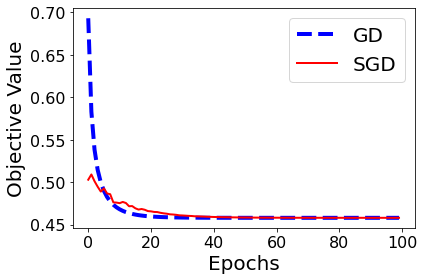

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1], ['GD', 'SGD'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)

# 5. Prediction

In [15]:
# Predict class label
# Inputs:
#     w: d-by-1 matrix
#     X: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

In [16]:
# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.2203125


In [17]:
# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.2734375


# 6. Mini-batch SGD (fill the code)



## 6.1. Compute the objective $Q_I$ and its gradient using a batch of samples

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [77]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: d-by-1 matrix
#     xi: b-by-d matrix
#     yi: b-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
    
def mb_stochastic_objective_gradient(w, x_mini, y_mini, lam, b):
    # Fill the function
    # Follow the implementation of stochastic_objective_gradient
    # Use matrix-vector multiplication; do not use FOR LOOP of vector-vector multiplications
    d = x_mini.shape[0]
    
    
    obj_mean = 0 #store obj values
    grad_mean = 0 #store gradient values
    for i in range(b):
        # calculate objective function Q_i
        x = x_mini[i, :]
        y = float(y_mini[i, :])
        yx = y * x # 1-by-d matrix
        yxw = float(numpy.dot(yx, w)) # scalar
        loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
        
        #calculate gradient loss 
        g_loss = (-yx.T / (1 + numpy.exp(yxw))) # d-by-1 matrix
        
        obj_mean += loss #sum obj 
        grad_mean += g_loss #sum gradient
        
    reg = lam / 2 * numpy.sum(w * w) # scalar
    if b == 8:
        obj_mean /= b *80
    else:
        obj_mean /= b*10
    obj = obj_mean + reg #objective function Q_i  
    grad_mean /= b
    g = grad_mean + lam * w # d-by-1 matrix

   
    return obj, g

## 6.2. Implement mini-batch SGD

Hints:
1. In every epoch, randomly permute the $n$ samples (just like SGD).
2. Each epoch has $\frac{n}{b}$ iterations. In every iteration, use $b$ samples, and compute the gradient and objective using the ``mb_stochastic_objective_gradient`` function. In the next iteration, use the next $b$ samples, and so on.


In [52]:
def create_mini_batches(x, y, b):   #function to create mini batches
    d = x.shape[0]            
    mini_batches = []         #setting up empty list to store values
    no_batches = d//b         #determing batch size 
    data = numpy.column_stack((x, y)) #concatenate x and y  
    numpy.random.shuffle(data)
    m = 0
        
    for m in range(no_batches):      #for loop to create the batches 
        mini_batch = data[m*b:(m+1)*b, :]  #index to create next batch
        x_mini = mini_batch[:, :-1]
        y_mini = mini_batch[:, -1].reshape((-1,1))
        mini_batches.append((x_mini, y_mini))  #add  batch to the list
    return mini_batches

In [53]:
# Mini-Batch SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def mb_sgd(x, y, lam, b, stepsize, max_epoch=100, w=None):
    # Fill the function
    # Follow the implementation of sgd
    # Record one objective value per epoch (not per iteration!)
    ...
    n = x.shape
    d = x.shape[0]
    c = x.shape[1]
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((c, 1)) # zero initialization
    no_batches = d//b   #number of batches
    
    for t in range(max_epoch):
        objval = 0 # accumulate the objective values
        for i in range(no_batches):
            mini_batches = create_mini_batches(x, y, b)  #create mini batches
            for mini_batch in mini_batches:
                x_mini, y_mini = mini_batch
                
                obj, g = mb_stochastic_objective_gradient(w, x_mini, y_mini, lam, b)
                objval += obj
                w -= stepsize * g
        
        stepsize *= 0.9 # decrease step size
        objval /= no_batches   
        objvals[t] = objval 
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

## 6.3. Run MB-SGD

In [71]:
# stepsize parameter tuning using k-fold cross validation
from sklearn.model_selection import KFold 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

C_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2]  #step parameters

for value in C_values:
    kf10 = KFold(n_splits=10, shuffle=True)   #split data into 10 folds
    model = LogisticRegression(C=value)    #use regression for model

    results = cross_val_score(model, x_train, numpy.ravel(y_train), cv = kf10, scoring='accuracy') # check accuracy scores
    print("P Value :", value, (results.mean()*100.0, results.std()*100.0))



P Value : 0.1 (76.40625, 7.637093381156211)
P Value : 0.2 (76.875, 6.547602137424049)
P Value : 0.3 (76.40625, 3.792081593597374)
P Value : 0.4 (76.5625, 5.6768444139327965)
P Value : 0.5 (76.71875, 7.376919771320548)
P Value : 0.6 (77.34375, 5.146771591250189)
P Value : 0.7 (76.09375, 6.406249999999999)
P Value : 0.8 (76.40625, 5.609788459692576)
P Value : 0.9 (77.5, 5.510997527671375)
P Value : 1 (77.03125, 6.556917268236652)
P Value : 1.5 (76.5625, 5.54632479665589)
P Value : 2 (77.34375, 4.903860883273505)


Stepvalue of 0.9 has the highest accuracy. I will use this number moving forward 

In [78]:
# MB-SGD with batch size b=8
lam = 1E-6 # do not change
b = 8 # do not change
stepsize = 0.9 # you must tune this parameter

w, objvals_mbsgd8 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch t=0 is 0.535280810409252
Objective value at epoch t=1 is 0.5283500822504583
Objective value at epoch t=2 is 0.5228930805214691
Objective value at epoch t=3 is 0.5177742303218384
Objective value at epoch t=4 is 0.5130493930777495
Objective value at epoch t=5 is 0.5094617039406345
Objective value at epoch t=6 is 0.5058116984942724
Objective value at epoch t=7 is 0.5036684885533376
Objective value at epoch t=8 is 0.49926896922570546
Objective value at epoch t=9 is 0.4970693124141293
Objective value at epoch t=10 is 0.49508238355146955
Objective value at epoch t=11 is 0.4928282627212567
Objective value at epoch t=12 is 0.49144732177295075
Objective value at epoch t=13 is 0.4892004540207435
Objective value at epoch t=14 is 0.4883296370447301
Objective value at epoch t=15 is 0.4868444081398751
Objective value at epoch t=16 is 0.48584387264131335
Objective value at epoch t=17 is 0.48446960933432087
Objective value at epoch t=18 is 0.4836111107043849
Objective value at

In [72]:
# MB-SGD with batch size b=64
lam = 1E-6 # do not change
b = 64 # do not change
stepsize = 0.9 # you must tune this parameter

w, objvals_mbsgd64 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch t=0 is 0.4893025139122991
Objective value at epoch t=1 is 0.48135450908263494
Objective value at epoch t=2 is 0.4803255633248404
Objective value at epoch t=3 is 0.47949110600172
Objective value at epoch t=4 is 0.47919022528525046
Objective value at epoch t=5 is 0.47840880769348193
Objective value at epoch t=6 is 0.4779754676611729
Objective value at epoch t=7 is 0.4776133131745959
Objective value at epoch t=8 is 0.47692419545330533
Objective value at epoch t=9 is 0.4768724034989923
Objective value at epoch t=10 is 0.47615595552475654
Objective value at epoch t=11 is 0.47652498698526785
Objective value at epoch t=12 is 0.47575626776713786
Objective value at epoch t=13 is 0.4755007694338203
Objective value at epoch t=14 is 0.47548058016166433
Objective value at epoch t=15 is 0.47497106959556257
Objective value at epoch t=16 is 0.4749803962156071
Objective value at epoch t=17 is 0.47479084024544854
Objective value at epoch t=18 is 0.4745427263533605
Objective valu

# 7. Plot and compare GD, SGD, and MB-SGD

You are required to compare the following algorithms:

- Gradient descent (GD)

- SGD

- MB-SGD with b=8

- MB-SGD with b=64

Follow the code in Section 4 to plot ```objective function value``` against ```epochs```. There should be four curves in the plot; each curve corresponds to one algorithm.

Hint: Logistic regression with $\ell_2$-norm regularization is a strongly convex optimization problem. All the algorithms will converge to the same solution. **In the end, the ``objective function value`` of the 4 algorithms will be the same. If not the same, your implementation must be wrong. Do NOT submit wrong code and wrong result!**

<ipython-input-79-87712f56ef7f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
<ipython-input-79-87712f56ef7f>:13: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
<ipython-input-79-87712f56ef7f>:14: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line2, = plt.plot(epochs_mbsgd8, objvals_mbsgd8, '-g', LineWidth=2)
<ipython-input-79-87712f56ef7f>:15: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line3, = plt.plot(epochs_mbsgd64, objvals_mbsgd64, '-m', LineWidth=2)
<ipython-input-79-87712f56ef7f>:16: MatplotlibDepre

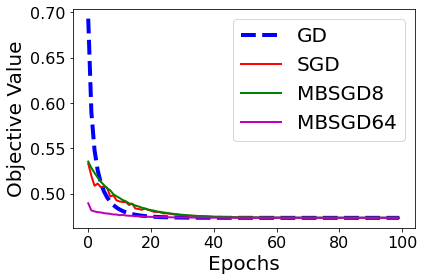

In [79]:
# plot the 4 curves:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))
epochs_mbsgd8 = range(len(objvals_mbsgd8))
epochs_mbsgd64 = range(len(objvals_mbsgd64))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
line2, = plt.plot(epochs_mbsgd8, objvals_mbsgd8, '-g', LineWidth=2)
line3, = plt.plot(epochs_mbsgd64, objvals_mbsgd64, '-m', LineWidth=2)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1, line2, line3], ['GD', 'SGD', 'MBSGD8', 'MBSGD64'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd_mbsgd8_mbsgd64.pdf', format='pdf', dpi=1200)